## Objective

To predict target. The notebook was divided into the following sections:
- Importings
- EDA
- Model

## Importings

In [2]:
import pandas as pd
import numpy as np
from yellowbrick.model_selection import rfecv
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import dabl
from scipy import stats
import researchpy as rp
from statsmodels.formula.api import glm
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
import timeit
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

In [43]:
df = pd.read_csv('dataset_test_ds.csv', sep=';')

## EDA

In [3]:
df.head()

,V1,V2,V3,TARGET,V4,V5,V6,V7,V8,V9,V10,Safra
0,0,8.1,9.99,0,1968,0,0,15.15,0,0,0,201901
1,0,4.4,35.00,0,1369,0,0,63.98,1,0,0,201910
2,0,0.7,52.99,0,1228,0,0,98.84,0,0,0,201906
3,0,63.3,810.00,0,0,0,1,9237.21,0,0,0,201910
4,0,4.1,17.50,0,0,0,1,27.70,1,0,0,201902


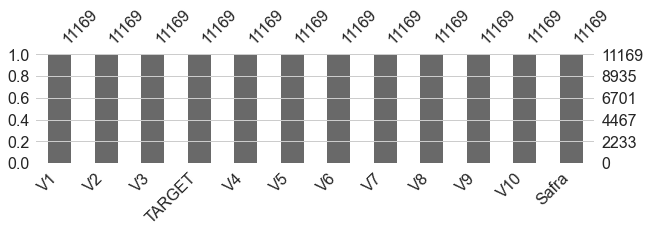

In [4]:
msno.bar(df, figsize=(10, 2))
plt.show()

In [5]:
df.nunique()

V1           2
V2         959
V3        3292
TARGET       2
V4        1864
V5          12
V6           2
V7        9066
V8           2
V9           2
V10          2
Safra       12
dtype: int64

Quick analysis:
- target is unbalanced

Target looks like classification
Linear Discriminant Analysis training set score: 0.650


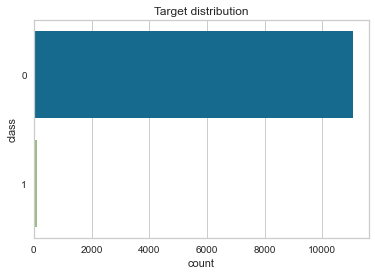

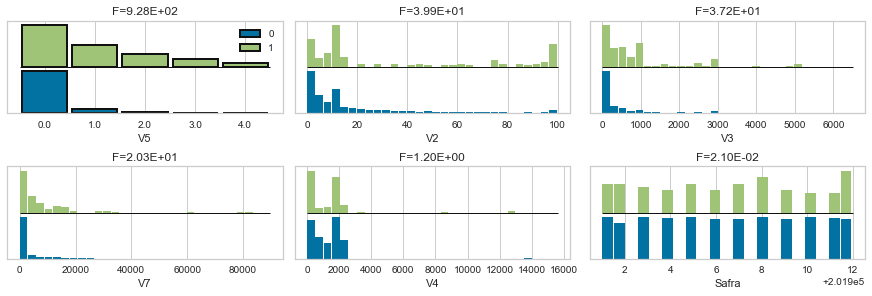

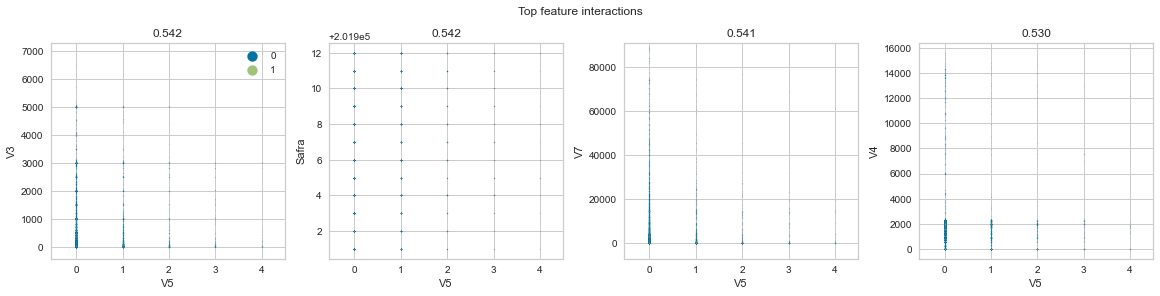

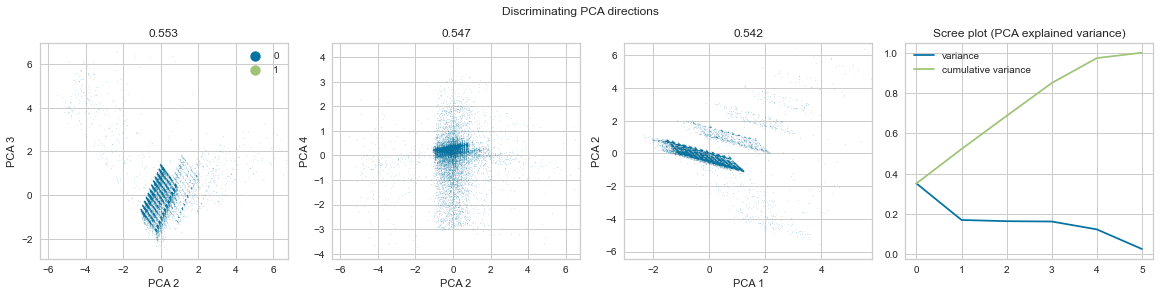

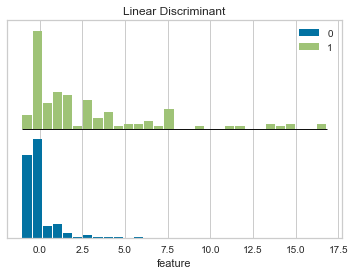

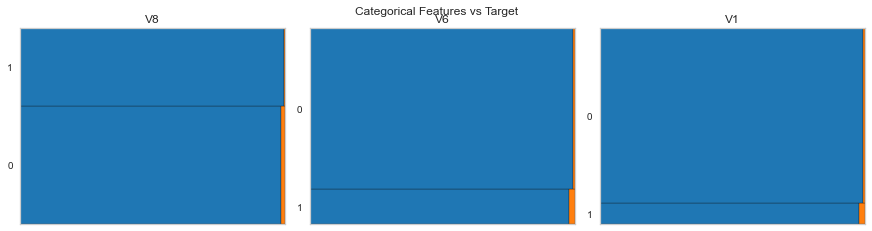

In [4]:
dabl.plot(df, target_col='TARGET')

Sanity check:
- counts of target for each safra
- percentage of target for each safra

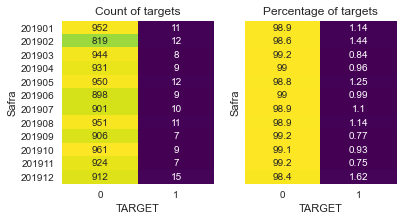

In [128]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
sns.heatmap(pd.crosstab(df['Safra'], df['TARGET']), 
            annot=True, cmap='viridis', fmt='.3g', cbar=False, ax=ax[0])

ax[0].set_title('Count of targets')

sns.heatmap(pd.crosstab(df['Safra'],df['TARGET'])\
            .apply(lambda r: round(r/r.sum()*100, 2), axis=1),
            annot=True, cmap='viridis', fmt='.3g', cbar=False, ax=ax[1])

ax[1].set_title('Percentage of targets')
plt.show()

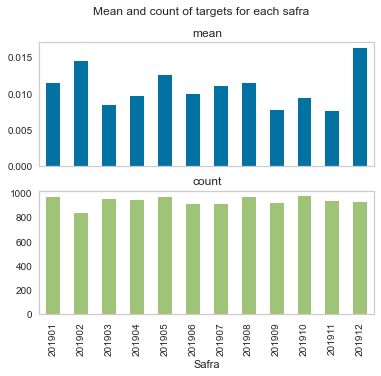

In [139]:
df.groupby('Safra')['TARGET'].agg(['mean', 'count']).\
    plot(kind='bar', subplots=True, figsize=(6, 5), grid=False,
         title='Mean and count of targets for each safra', legend=False)
plt.show()

In [8]:
cols_non_binary = ['V2', 'V3', 'V4', 'V5', 'V7', 'TARGET']
cols_binary = ['V1', 'V6', 'V8', 'V9', 'V10', 'TARGET']

Looking at normalized features, we can see that it seems to contain some outliers

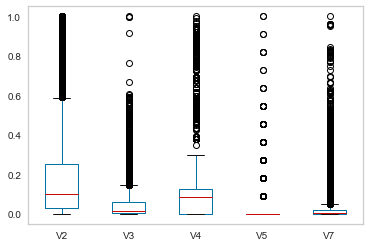

In [144]:
df_scaler = MinMaxScaler().fit_transform(df[cols_non_binary].drop('TARGET', axis=1))

pd.DataFrame(df_scaler, columns=cols_non_binary[:-1]).plot(kind='box', figsize=(6, 4), grid=False)
plt.show()

In [145]:
cols_non_binary

['V2', 'V3', 'V4', 'V5', 'V7', 'TARGET']

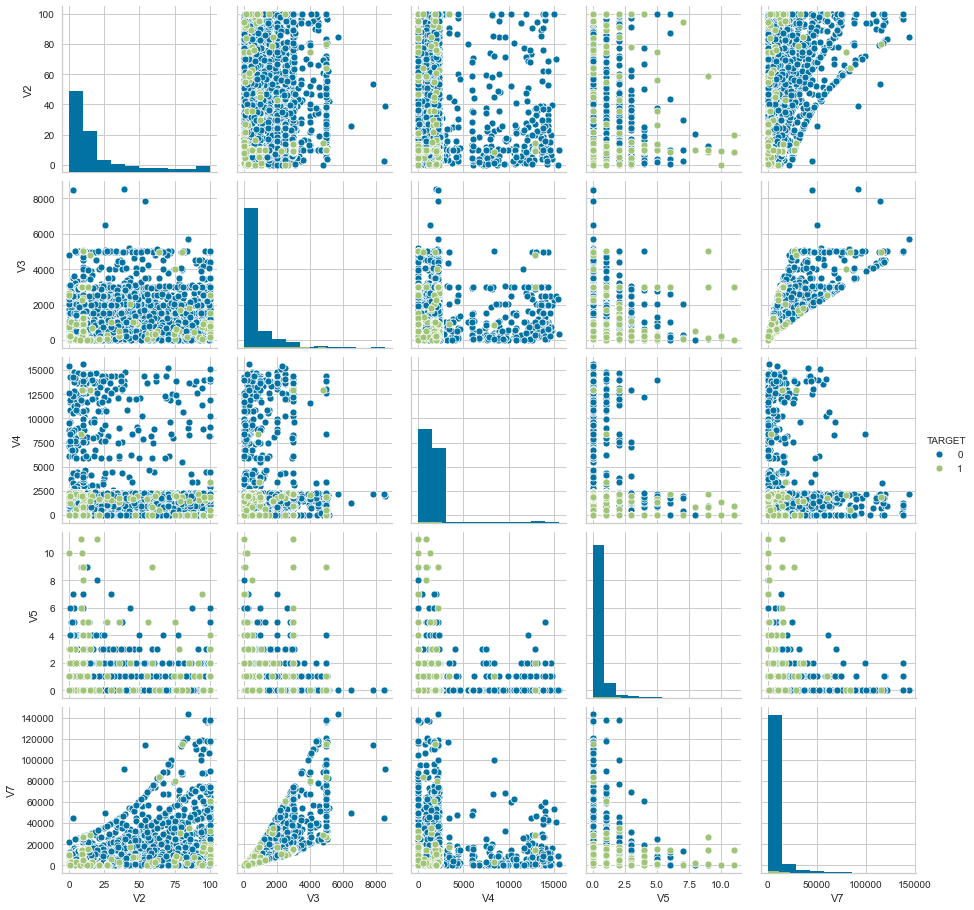

In [9]:
sns.pairplot(df[cols_non_binary], hue='TARGET', diag_kind='hist')
plt.show()

In [146]:
cols_binary

['V1', 'V6', 'V8', 'V9', 'V10', 'TARGET']

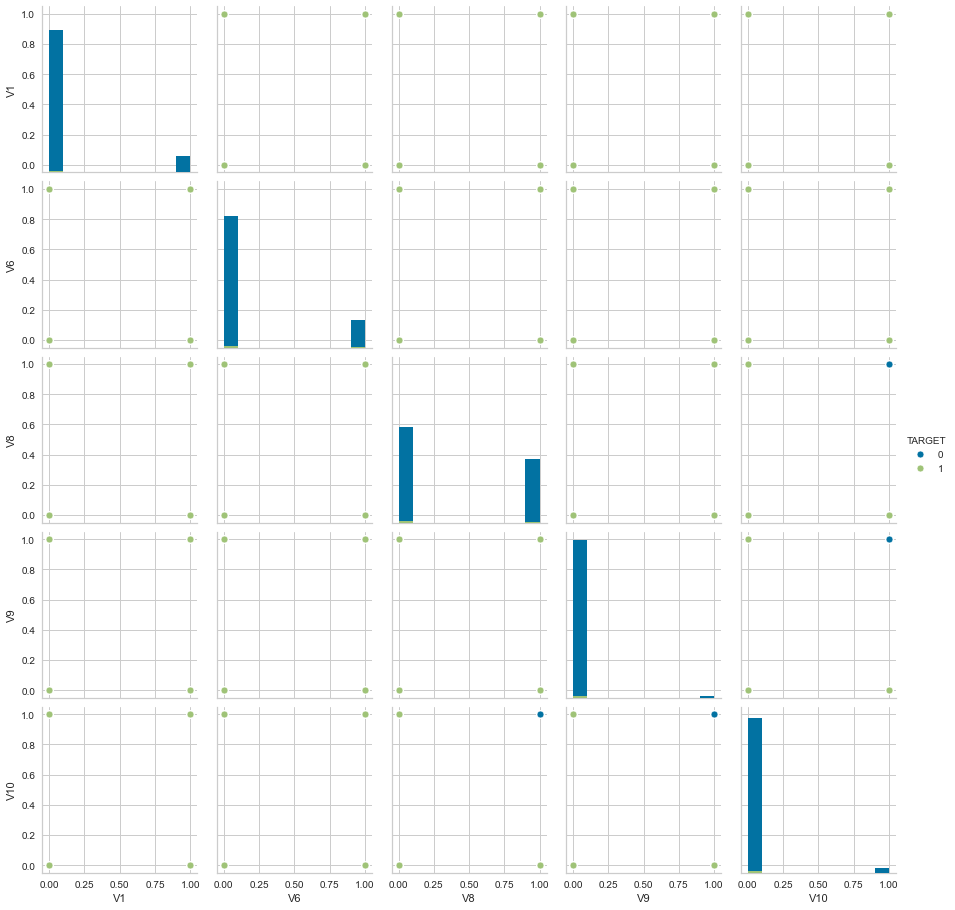

In [13]:
sns.pairplot(df[cols_binary], hue='TARGET', diag_kind='hist')

The previous plot show that the pairs `V8 + V10` and `V9 + V10` seem to discriminate the target

In [17]:
mask_v8 = (df['V10']==1) & (df['V8']==1)
mask_v9 = (df['V10']==1) & (df['V9']==1)

df['V10_8'] = np.where(mask_v8, 1, 0)
df['V10_9'] = np.where(mask_v9, 1, 0)

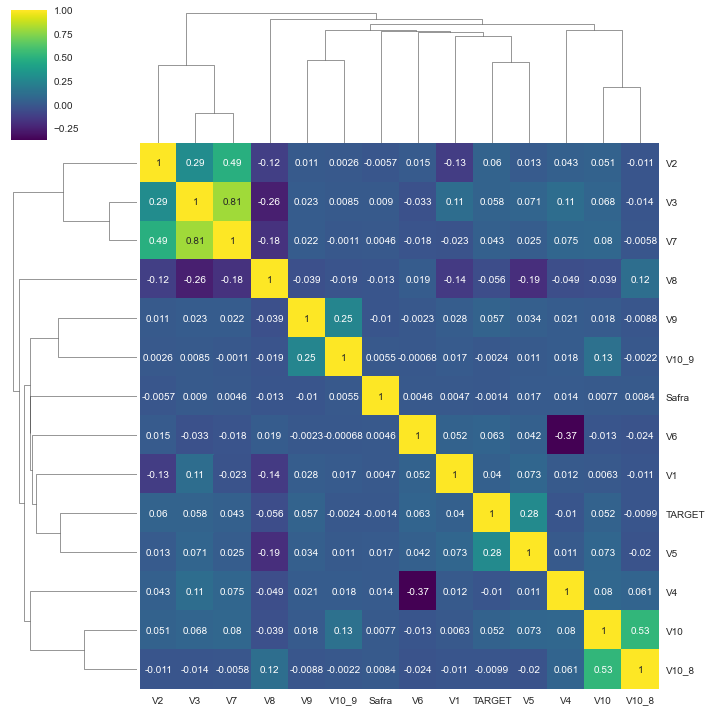

In [18]:
sns.clustermap(df.corr(), cmap='viridis', annot=True)
plt.show()

In [19]:
def df_correlations(df):
    '''
    Calculate pearson correlation between features
    Returns: dataframe with the correlation of each different pair of features
    '''    
    lst_cols = []
    cols = df.corr().columns.tolist()

    for col_1 in cols:
        for col_2 in cols:
            lst_cols.append(col_1 + ' + ' + col_2)

    df_corr = pd.Series(df.corr().values.reshape(-1), index=lst_cols)
    df_corr = df_corr[df_corr!=1]
    df_corr.drop_duplicates(inplace=True)
    df_corr = df_corr.sort_values(ascending=False).to_frame(name='pearson_correlation')
    
    return df_corr

df_corr = df_correlations(df)

Plotting the top 5 positive and negative pearson correlations

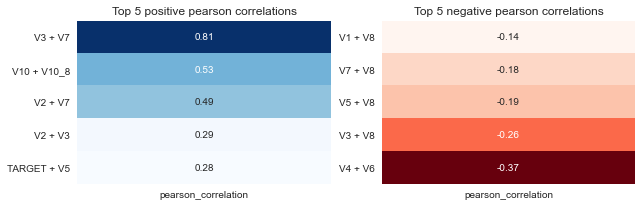

In [153]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].set_title('Top 5 positive pearson correlations')
sns.heatmap(df_corr.head(), annot=True, cmap='Blues', ax=ax[0], cbar=False)
ax[1].set_title('Top 5 negative pearson correlations')
sns.heatmap(df_corr.tail(), annot=True, cmap='Reds_r', ax=ax[1], cbar=False)
plt.show()

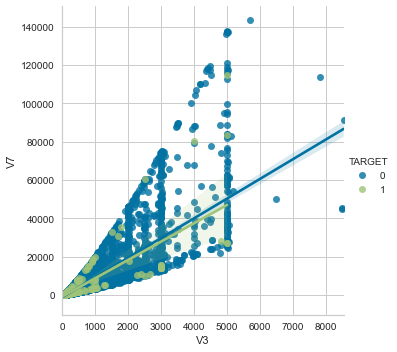

In [21]:
sns.lmplot(data=df, x='V3', y='V7', hue='TARGET')

Analyzing whether categorical correlation have any relationship with the target

In [165]:
def stats_chi2(df, index, col, p_val_threshold=0.05, figsize=(10, 2)):
    '''
    Calculate chi-square statistics and relationship between two categorical features
    Returns:     chi-square and cramer's V statistics, and plot contigency table
    '''
    table, results = rp.crosstab(df[index], df[col], prop='col', test='chi-square')
    p_value, cramers_v = results.loc[1, 'results'], results.loc[2, 'results']
    plt.figure(figsize=figsize)
    sns.heatmap(table.iloc[:-1, :-1] , annot=True, cmap='vlag_r', annot_kws={"size": 15}, cbar=False)
    plt.xlabel('')
    plt.show()
    
    if p_value < p_val_threshold:
        print(f'p-value is {p_value}, lower than {p_val_threshold}, so we reject the null hypothesis of independence')
        print(f'The strenght of the relationship between {index} and {col} is {cramers_v}')
        
    else:
        print(f'p-value is {p_value}, greater than {p_val_threshold}, so we fail reject the null hypothesis of independence')
        print(f'Chi-square test did not identified a relationship between {index} and {col}')

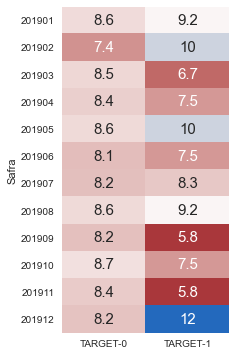

p-value is 0.8307, greater than 0.05, so we fail reject the null hypothesis of independence
Chi-square test did not identified a relationship between Safra and TARGET


In [166]:
stats_chi2(df, 'Safra', 'TARGET', figsize=(3, 6))

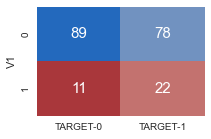

p-value is 0.0, lower than 0.05, so we reject the null hypothesis of independence
The strenght of the relationship between V1 and TARGET is 0.0401


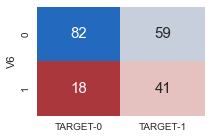

p-value is 0.0, lower than 0.05, so we reject the null hypothesis of independence
The strenght of the relationship between V6 and TARGET is 0.0628


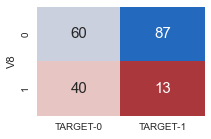

p-value is 0.0, lower than 0.05, so we reject the null hypothesis of independence
The strenght of the relationship between V8 and TARGET is 0.0563


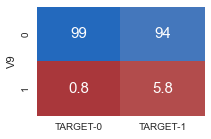

p-value is 0.0, lower than 0.05, so we reject the null hypothesis of independence
The strenght of the relationship between V9 and TARGET is 0.0565


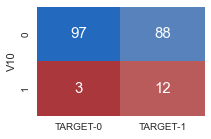

p-value is 0.0, lower than 0.05, so we reject the null hypothesis of independence
The strenght of the relationship between V10 and TARGET is 0.0522


In [167]:
col_bin = [col for col in cols_binary if 'TARGET' not in col]

for col in col_bin:
    stats_chi2(df, col, 'TARGET', figsize=(3, 2))
    plt.show()

Using `Logistic Regression` and `Decision Tree` to identify important features to discriminate the target

In [25]:
def split_feat_target(df, target='TARGET', dropcol='Safra'):    
    x, y = df.drop([dropcol, target], axis=1), df[target]
    return x, y

In [170]:
x, y = split_feat_target(df)

In [171]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(x, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

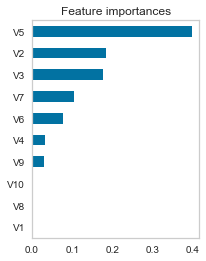

In [176]:
pd.Series(dt.feature_importances_, index=x.columns).sort_values().plot.barh(figsize=(3, 4), grid=False, title='Feature importances')
plt.show()

Using all safras, we can see that `V5` is the most important feature

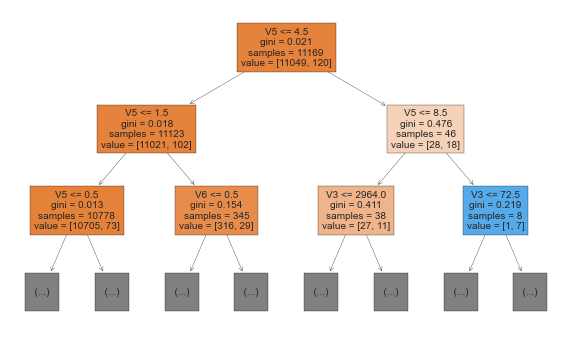

In [29]:
plt.figure(figsize=(10, 6))
plot_tree(dt, max_depth=2, feature_names=x.columns, filled=True, fontsize=10)
plt.show()

Now we can see the importance of each feature for each safra

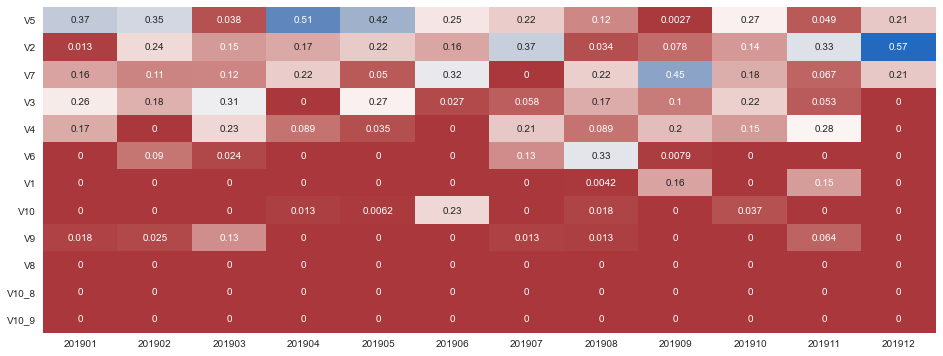

In [30]:
df_safra_dt = pd.DataFrame(index=x.columns)

for safra in sorted(df['Safra'].unique()):
    x, y = split_feat_target(df[df['Safra']==safra])
    dt.fit(x, y)
    df_safra_dt[safra] = dt.feature_importances_

df_safra_dt['sum'] = df_safra_dt.sum(axis=1)
df_safra_dt.sort_values('sum', ascending=False, inplace=True)

plt.figure(figsize=(16, 6))
sns.heatmap(df_safra_dt.iloc[:,:-1], cmap='vlag_r', annot=True, cbar=False)
plt.show()

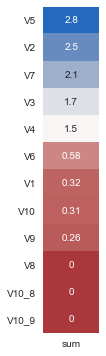

In [31]:
plt.figure(figsize=(1, 6))
sns.heatmap(df_safra_dt.iloc[:,-1].to_frame(), cmap='vlag_r', annot=True, cbar=False)
plt.show()

Now I will use logistic regression to analyze whether the variables are significant

In [32]:
x = sm.add_constant(x)
lr = GLM(y, x, family=sm.families.Binomial())
lr_results = lr.fit(maxiter=1000)

In [33]:
print(lr_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 TARGET   No. Observations:                  927
Model:                            GLM   Df Residuals:                      914
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -62.195
Date:                Sat, 16 May 2020   Deviance:                       124.39
Time:                        08:41:37   Pearson chi2:                 1.07e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1646      0.693     -7.451      0.0

Sadly the two features that I created `V10_8` and `V10_9` are not significant according to their p-values.

I will remove them and run again the logistic regression

In [46]:
x, y = split_feat_target(df)

x = sm.add_constant(x)
lr = GLM(y, x.drop(['V10_8', 'V10_9'], axis=1), family=sm.families.Binomial())
lr_results = lr.fit(maxiter=1000)
print(lr_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 TARGET   No. Observations:                11169
Model:                            GLM   Df Residuals:                    11158
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -508.77
Date:                Sat, 16 May 2020   Deviance:                       1017.5
Time:                        08:54:07   Pearson chi2:                 9.46e+03
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0198      0.244    -24.626      0.0

In [37]:
df.drop(['V10_8', 'V10_9'], axis=1, inplace=True)

I will analyze the p-value for each safra

In [47]:
df_safra_lr = pd.DataFrame()

for safra in sorted(df['Safra'].unique()):
    x, y = split_feat_target(df[df['Safra']==safra])
    x = sm.add_constant(x)
    lr = GLM(y, x, family=sm.families.Binomial())
    lr_results = lr.fit(maxiter=1000)
    df_safra_lr[safra] = lr_results.pvalues

df_safra_lr.drop('const', inplace=True)

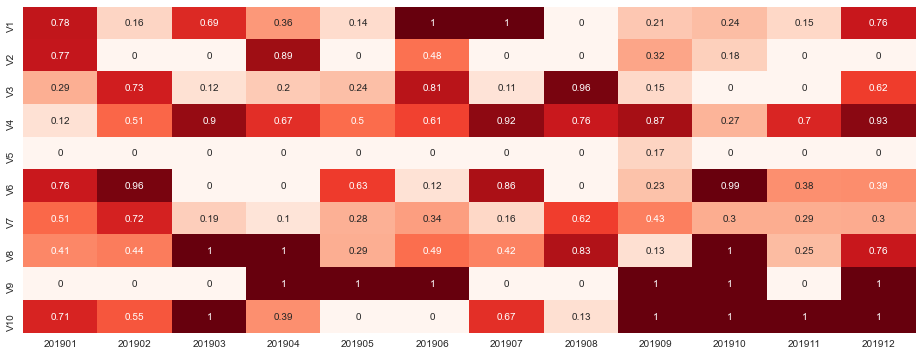

In [50]:
threshold = 0.1

plt.figure(figsize=(16, 6))
sns.heatmap(pd.DataFrame(np.where(df_safra_lr > threshold, df_safra_lr, 0),
             index=df_safra_lr.index, columns=df_safra_lr.columns), cmap='Reds', annot=True, cbar=False)
plt.show()

`V5` seems to be significant for most of the safras.

I will analyze the number and percentage of target for each V5 for each Safra

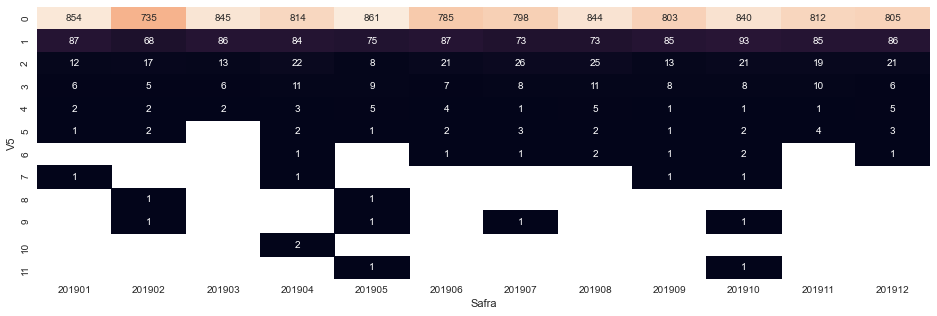

In [51]:
plt.figure(figsize=(16, 5))
sns.heatmap(pd.pivot_table(data=df, index='V5', columns='Safra', values='TARGET', aggfunc='count'),
            annot=True, fmt='.3g', cbar=False)
plt.show()

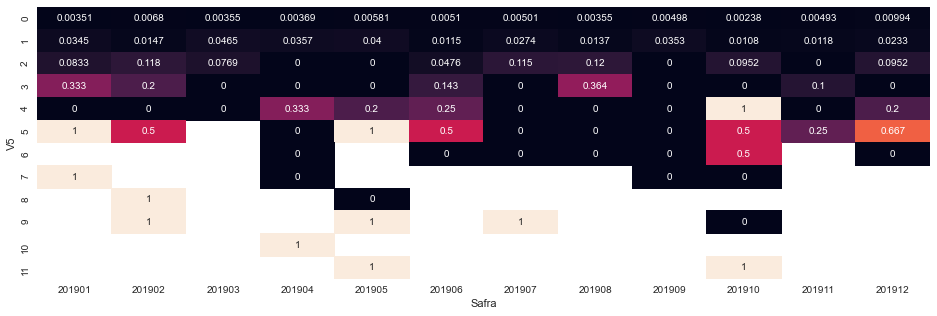

In [52]:
plt.figure(figsize=(16, 5))
sns.heatmap(pd.pivot_table(data=df, index='V5', columns='Safra', values='TARGET', aggfunc='mean'),
            annot=True, fmt='.3g', cbar=False)
plt.show()

## Model

I will keep all variables and try several models.

I stratified the trainset and testset by target and safra.

In order to deal with unbalanced data, I applied `RandomUnderSampler` and used `MinMaxScaler` to normalize the numerical data.

Then I applied `GroupKFold` grouping by safra and applied gridsearch to optimize hyperparameters for each classifier

In [53]:
def train_test(df=df, target='TARGET', safra='Safra'):
    '''
    Split the dataframe into features and target for trainset and testset
    Returns: trainsets and testsets
    '''
    x, y = df.drop([target], axis=1), df[target]
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=df[[target, safra]], random_state=42)
    return x_train, x_test, y_train, y_test

In [54]:
sampler = RandomUnderSampler(random_state=42)
scaler = MinMaxScaler()

In [55]:
def train_clf(df, param_grid, clf, sampler=sampler, gkf=GroupKFold(n_splits=12), scaler=scaler):    
    '''
    Create pipeline with the chosen sampler, scaler, and classifier
    Train pipeline tuning the hyperparameters with gridsearch,
           optimizing f1_weighted
    Returns: dataframe with predicted and real values,
             pipeline with the best parameters
    '''        
    df_pred = pd.DataFrame()
    x_train, x_test, y_train, y_test = train_test(df)
    
    groups = x_train['Safra']
    gkf = list(gkf.split(x_train, y_train, groups))
    x_train, x_test = x_train.drop('Safra', axis=1), x_test.drop('Safra', axis=1)
        
    print(f'Model: {clf.__class__.__name__}')    
    start = timeit.default_timer()    
    pipe = Pipeline([('sampler', sampler), ('scaler', scaler), ('clf', clf)])
    grid = GridSearchCV(pipe, param_grid, scoring='f1', n_jobs=-1, cv=gkf)
    grid.fit(x_train, y_train)
    print(f'Executed in {round(timeit.default_timer() - start, 0)} secs')
    y_pred = grid.predict(x_test)
    print(f'Best params: {grid.best_params_}')
    print(f'Trainset f1-score: {grid.best_score_}')
    print(classification_report(y_pred, y_test))        
        
    df_pred['y_pred'] = y_pred.tolist()
    df_pred['y_test'] = y_test.tolist()
    
    return df_pred, grid.best_estimator_

In [90]:
param_grid = {'clf__penalty': ['l1', 'l2'],
              'clf__C': np.logspace(0, 3, 50)}

df_pred_lr, clf_lr = train_clf(df, param_grid, LogisticRegression(random_state=42, solver='liblinear'))

Model: LogisticRegression
Executed in 16.0 secs
Best params: {'clf__C': 3.5564803062231287, 'clf__penalty': 'l1'}
Trainset f1-score: 0.0880251625960134
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      2295
           1       0.60      0.04      0.07       498

    accuracy                           0.82      2793
   macro avg       0.71      0.52      0.49      2793
weighted avg       0.79      0.82      0.75      2793



In [91]:
param_grid = {'clf__alpha': np.linspace(0.1, 1, 30),
              'clf__fit_prior': [True, False]}

df_pred_nb, clf_nb = train_clf(df, param_grid, BernoulliNB())

Model: BernoulliNB
Executed in 3.0 secs
Best params: {'clf__alpha': 0.28620689655172415, 'clf__fit_prior': True}
Trainset f1-score: 0.06497085359491224
              precision    recall  f1-score   support

           0       0.72      0.99      0.84      2006
           1       0.63      0.02      0.05       787

    accuracy                           0.72      2793
   macro avg       0.68      0.51      0.44      2793
weighted avg       0.70      0.72      0.61      2793



In [92]:
param_grid = {'clf__max_depth': np.arange(2, 20),
              'clf__min_samples_leaf': [70, 80, 100, 120, 150, 200]}

df_pred_dt, clf_dt = train_clf(df, param_grid, DecisionTreeClassifier(random_state=42, class_weight='balanced'))

Model: DecisionTreeClassifier
Executed in 5.0 secs
Best params: {'clf__max_depth': 2, 'clf__min_samples_leaf': 70}
Trainset f1-score: 0.03816475920170067
              precision    recall  f1-score   support

           0       0.53      1.00      0.69      1463
           1       0.80      0.02      0.04      1330

    accuracy                           0.53      2793
   macro avg       0.66      0.51      0.36      2793
weighted avg       0.66      0.53      0.38      2793



In [93]:
param_grid = {'clf__n_neighbors': np.arange(3, 20),
              'clf__weights': ['uniform', 'distance'],
              'clf__metric': ['euclidean', 'manhattan']}

df_pred_knn, clf_knn = train_clf(df, param_grid, KNeighborsClassifier())

Model: KNeighborsClassifier
Executed in 6.0 secs
Best params: {'clf__metric': 'manhattan', 'clf__n_neighbors': 12, 'clf__weights': 'uniform'}
Trainset f1-score: 0.10025299190570403
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      2312
           1       0.43      0.03      0.05       481

    accuracy                           0.83      2793
   macro avg       0.63      0.51      0.48      2793
weighted avg       0.76      0.83      0.76      2793



In [94]:
param_grid = {'clf__kernel': ['linear', 'rbf'],
              'clf__C': [1, 5, 8, 10, 12, 15, 20]}

df_pred_svm, clf_svm = train_clf(df, param_grid, SVC())

Model: SVC
Executed in 1.0 secs
Best params: {'clf__C': 12, 'clf__kernel': 'linear'}
Trainset f1-score: 0.08361016229778574
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      2247
           1       0.63      0.03      0.07       546

    accuracy                           0.81      2793
   macro avg       0.72      0.51      0.48      2793
weighted avg       0.77      0.81      0.73      2793



In [95]:
param_grid = {'clf__n_estimators': [100, 150, 200],
              'clf__max_depth': np.arange(4, 10),
              'clf__max_features': [0.8, 1],
              'clf__n_jobs': [-1]}

df_pred_rf, clf_rf = train_clf(df, param_grid, RandomForestClassifier(random_state=42))

Model: RandomForestClassifier
Executed in 36.0 secs
Best params: {'clf__max_depth': 8, 'clf__max_features': 1, 'clf__n_estimators': 150, 'clf__n_jobs': -1}
Trainset f1-score: 0.07527404021341187
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      2162
           1       0.73      0.03      0.07       631

    accuracy                           0.78      2793
   macro avg       0.76      0.52      0.47      2793
weighted avg       0.77      0.78      0.69      2793



In [96]:
param_grid = {'clf__n_estimators': [80, 100, 200],
              'clf__base_estimator': [DecisionTreeClassifier(), LogisticRegression()],
              'clf__learning_rate': [0.2, 0.1, 0.05]}

df_pred_ada, clf_ada = train_clf(df, param_grid, AdaBoostClassifier(random_state=42))

Model: AdaBoostClassifier
Executed in 15.0 secs
Best params: {'clf__base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'clf__learning_rate': 0.2, 'clf__n_estimators': 200}
Trainset f1-score: 0.06045761117380097
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      2082
           1       0.60      0.03      0.05       711

    accuracy                           0.75      2793
   macro avg       0.67      0.51      0.45      2793
weighted avg       0.71      0.75      0.65      2793



In [97]:
param_grid = {'clf__n_estimators': [50, 100],
              'clf__max_depth': np.arange(2, 11),
              'clf__learning_rate': [1, 0.5, 0.1, 0.01, 0.001]}

df_pred_gb, clf_gb = train_clf(df, param_grid, GradientBoostingClassifier(random_state=42))

Model: GradientBoostingClassifier
Executed in 23.0 secs
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 2, 'clf__n_estimators': 50}
Trainset f1-score: 0.07749139427878643
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      2270
           1       0.57      0.03      0.06       523

    accuracy                           0.81      2793
   macro avg       0.69      0.51      0.48      2793
weighted avg       0.77      0.81      0.74      2793



We can analyze the metrics for each pipeline below:

In [98]:
def clf_results(df_pred, name='name', y_test='y_test', y_pred='y_pred'):
    '''
    Organize classification metrics from classification_report for each classifier
    Returns: dataframe with classification metrics
    '''
    df_report = classification_report(df_pred[y_test], df_pred[y_pred], output_dict=True)
    df_report = pd.DataFrame(df_report)
    df_report = pd.concat([df_report.iloc[:3,1],
                           pd.Series(df_report.iloc[0,3],
                                     index=['accuracy'])]).to_frame(name=name)
    return df_report

In [99]:
results = {LogisticRegression().__class__.__name__: df_pred_lr,
           KNeighborsClassifier().__class__.__name__: df_pred_knn,
           BernoulliNB().__class__.__name__: df_pred_nb,
           SVC().__class__.__name__: df_pred_svm,
           DecisionTreeClassifier().__class__.__name__: df_pred_dt,
           RandomForestClassifier().__class__.__name__: df_pred_rf,
           AdaBoostClassifier().__class__.__name__: df_pred_ada,
           GradientBoostingClassifier().__class__.__name__: df_pred_gb}

df_results = pd.DataFrame(index=['precision', 'recall', 'f1-score', 'accuracy'])

for clf_name, df_pred in results.items():
    df_report = clf_results(df_pred, clf_name)
    df_results = df_results.join(df_report)


df_results = df_results.T

df_results.sort_values(['f1-score', 'accuracy', 'recall', 'precision'], 
                       inplace=True, ascending=False)

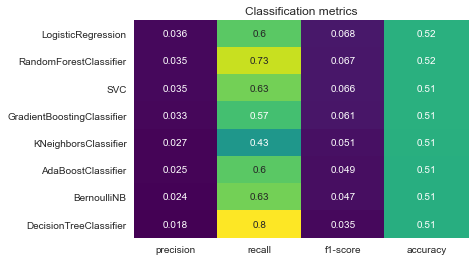

In [178]:
plt.title('Classification metrics')
sns.heatmap(df_results, annot=True, cmap='viridis', cbar=False)
plt.show()

Logistic regression seems to be the best model, so I will adopt it since it provides best explanations than random forest.

As we have seen from the logistic regression summary, there are some variables that may not be useful, so I will apply Recurrent Features Elimination to eliminate them.

In [57]:
clfs = {LogisticRegression().__class__.__name__: LogisticRegression(solver='liblinear'),
        DecisionTreeClassifier().__class__.__name__: DecisionTreeClassifier()}

In [58]:
def feature_selection(df, clfs=clfs, gkf=GroupKFold(12)):
    groups = df['Safra']
    x, y = split_feat_target(df)
    df_feat = pd.DataFrame(index=x.columns)
    gkf = list(gkf.split(x, y, groups))    
    for name, clf in clfs.items():
        rfe = rfecv(clf, x, y, scoring='f1', cv=gkf)
        print(f'{name} selected {rfe.n_features_} features out of {len(rfe.ranking_)}')
        print('='*80)
        df_feat[name] = rfe.ranking_
    return df_feat

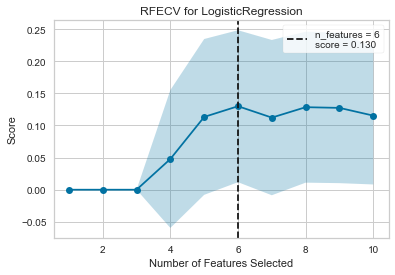

LogisticRegression selected 6 features out of 10


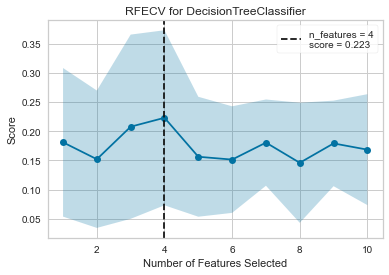

DecisionTreeClassifier selected 4 features out of 10


In [59]:
df_feat = feature_selection(df)

According to logistic regression, we should keep the features `V1`, `V5`, `V6`, `V8`, `V9`, and `V10`.

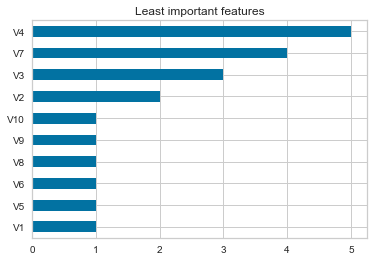

In [88]:
df_feat['LogisticRegression'].sort_values().plot.barh(title='Least important features')
plt.show()

In [103]:
useless_cols = df_feat[df_feat['LogisticRegression']>1].index.tolist()

In [110]:
param_grid = {'clf__penalty': ['l1', 'l2'],
              'clf__C': np.logspace(0, 3, 50)}

df_pred_lr, clf_lr = train_clf(df.drop(useless_cols, axis=1),
                               param_grid, LogisticRegression(random_state=42, solver='liblinear'))

Model: LogisticRegression
Executed in 4.0 secs
Best params: {'clf__C': 91.02981779915217, 'clf__penalty': 'l2'}
Trainset f1-score: 0.08141312727286132
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      2359
           1       0.50      0.03      0.06       434

    accuracy                           0.84      2793
   macro avg       0.67      0.51      0.49      2793
weighted avg       0.79      0.84      0.78      2793



I will analyze its performance for each safra

In [104]:
x_train, x_test, y_train, y_test = train_test(df.drop(useless_cols, axis=1))

In [111]:
df_results_test = pd.DataFrame(index=['precision', 'recall', 'f1-score', 'accuracy'])

for safra in sorted(x_test['Safra'].unique()):
    safra_index = x_test[x_test['Safra']==safra].index
    y_pred_safra = clf_lr.predict(x_test.loc[safra_index,:].drop('Safra', axis=1))
    y_test_safra = y_test[safra_index] 
    df_safra = pd.DataFrame()
    df_safra['y_test'] = y_test_safra
    df_safra['y_pred'] = y_pred_safra
    
    df_report_safra = clf_results(df_safra, name=safra)
    df_results_test = pd.concat([df_results_test, df_report_safra], axis=1)

In [112]:
df_safra = pd.DataFrame()
df_safra['y_test'] = y_test
df_safra['y_pred'] = clf_lr.predict(x_test.drop('Safra', axis=1))
df_report_safra = clf_results(df_safra, name='geral')
df_results_test = pd.concat([df_results_test, df_report_safra], axis=1)

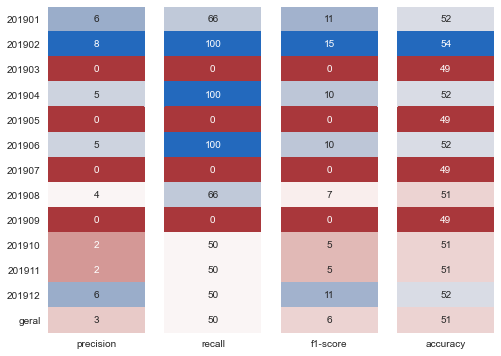

In [181]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(8, 6))
for i, index in enumerate(df_results_test.index):
    sns.heatmap((df_results_test*100).astype(int).loc[index,:].to_frame(), annot=True, fmt='.3g', cmap='vlag_r', cbar=False, ax=ax[i])
plt.show()

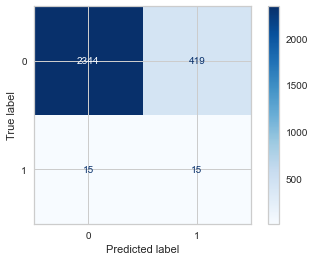

In [115]:
plot_confusion_matrix(clf_lr, x_test.drop('Safra', axis=1), y_test, cmap='Blues', values_format='.5g')
plt.show()

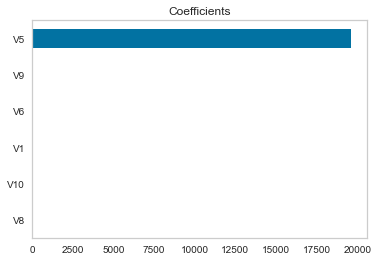

In [202]:
pd.Series(np.exp(clf_lr['clf'].coef_[0]), index=x_train.drop('Safra', axis=1).columns).sort_values().plot.barh(grid=False,
                                                                                                       title='Coefficients')
plt.show()